### Generate the estimated gravitational waveform and calculate the signal-to-noise for GW150914 with the Hanford Data ###

In [ ]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

In [1]:
#download the data
!curl -O -J https://raw.githubusercontent.com/ligo-cbc/binder/master/H-H1_LOSC_4_V2-1126259446-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1005k  100 1005k    0     0  1793k      0 --:--:-- --:--:-- --:--:-- 1798k


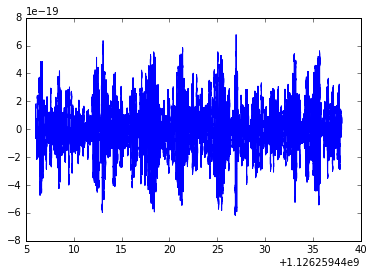

In [2]:
%matplotlib inline
import pylab
# Import the functions we need for later!
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.psd import welch, interpolate

# Read the Hanford data and remove low frequency content
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 16)

# Can you spot where the signal is beforehand?
pylab.plot(h1.sample_times, h1)

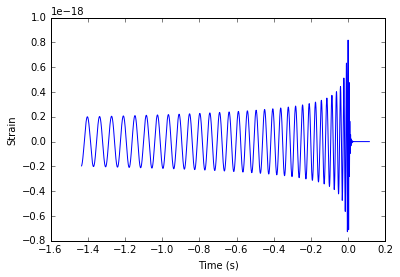

In [3]:
# Generate a waveform similar to GW150914 
# Change the parameters and see what happens to the waveform
# and the resulting SNR.

# Mass in Solar masses. 
m1 = 35.2
m2 = 34.0

# The intrinsic spin of each black hole
s1z = -0.228
s2z = -0.003

# The frequency to start generating the waveform
fstart = 15.0

hp, hc = get_td_waveform(approximant="SEOBNRv2",
                         mass1=m1, spin1z=s1z,
                         mass2=m2, spin2z=s2z,
                         f_lower=fstart,
                         delta_t=h1.delta_t)
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

# Move the waveform so that the merge is about at the end
# This means that an SNR spike later on in the data lines up with this point
hp.resize(len(h1))
hp.roll(int(hp.start_time * hp.sample_rate))

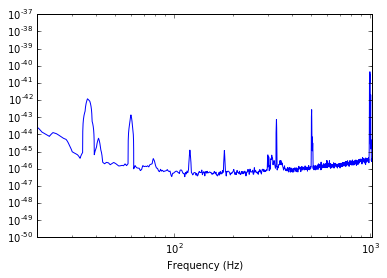

In [4]:
# Estimate the noise spectrum
# Normally we use more data to estimate the psd, but this is illustrative
psd = interpolate(welch(h1), 1.0 / h1.duration)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(20, 1024)
pylab.xlabel('Frequency (Hz)')

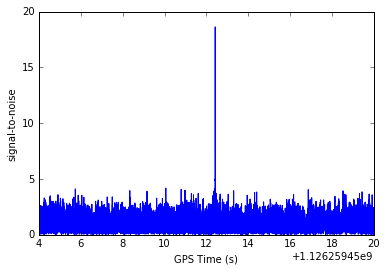

In [5]:
# Calculate the complex Signal-to-noise. This is a complex vector
# because the signal could have any phase.
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=30.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) / 4: len(snr) * 3 / 4]

# Now you should be able to spot where the signal is!
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()